In [1]:
from Embedders import SentenceTransformerEmbedder, EncoderEmbedder
embedder = SentenceTransformerEmbedder(model_name='BAAI/bge-small-en', device='mps', normalize=True)
print(embedder)
print(embedder.model.device)

BAAI/bge-small-en, device=mps, normalize=True
mps:0


In [3]:
import os

from dotenv import load_dotenv
from database.database import DatabaseProcessor

load_dotenv('.env', override=True)

# Database setup
db_params = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT')
}
db = DatabaseProcessor(db_params)
db.test_connection()

Python-dotenv could not parse statement starting at line 8


=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [3]:
from database.database import DatabaseProcessor
from dotenv import load_dotenv
import os

load_dotenv()
db_params = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
}
db = DatabaseProcessor(db_params)

db.test_connection()
print(db.db_params)

Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)
{'dbname': 'test', 'user': 'bbasseri', 'password': 'citeline25', 'host': 'localhost', 'port': '5432'}


In [14]:
import psycopg2
from time import time
conn = psycopg2.connect(**db.db_params)
cursor = conn.cursor()

cursor.execute('SELECT text FROM chunks;')
embedding_times = []
for i in range(30):
    rows = [row[0] for row in cursor.fetchmany(1024)]
    start = time()
    embeddings = embedder(rows)
    end = time()
    embedding_times.append(end - start)
    print(f'Batch {i+1} took {end - start:.2f} seconds. Shape: {embeddings.shape}')

print(f'Average time: {sum(embedding_times) / len(embedding_times):.2f} seconds')

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 1 took 9.85 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 2 took 9.30 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 3 took 8.97 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 4 took 9.12 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 5 took 9.56 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 6 took 9.35 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 7 took 9.61 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 8 took 10.10 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 9 took 9.77 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 10 took 10.63 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 11 took 10.73 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 12 took 10.16 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 13 took 10.15 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 14 took 10.35 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 15 took 10.48 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 16 took 10.56 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 17 took 10.63 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 18 took 10.84 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 19 took 9.95 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 20 took 10.08 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 21 took 9.87 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 22 took 9.94 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 23 took 10.23 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 24 took 9.93 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 25 took 9.71 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 26 took 9.12 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 27 took 9.11 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 28 took 9.05 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 29 took 8.96 seconds. Shape: (1024, 384)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batch 30 took 9.14 seconds. Shape: (1024, 384)
Average time: 9.84 seconds


In [4]:
import psycopg2
from time import time

averages = []
batch_size = 1
while batch_size < 2_500_000:
    try:
        # Get chunks from the database
        conn = psycopg2.connect(**db.db_params)
        cursor = conn.cursor()
        cursor.execute(
            f"SELECT text FROM chunks LIMIT {batch_size}")
        rows = cursor.fetchall()
        conn.close()
        chunks = [row[0] for row in rows]
        print(f"Got {len(chunks)} chunks")

        # Embed the chunks
        start = time()
        result = embedder(chunks)
        duration = time() - start
        print(f"Result shape: {result.shape}")
        averages.append(duration/batch_size)
        print(f"Batch size {batch_size} took {duration} seconds ({duration/batch_size} per chunk)")
        batch_size *= 2
    except Exception as e:
        print(e)
        break


Got 1 chunks
Result shape: (1, 768)
Batch size 1 took 0.3265950679779053 seconds (0.3265950679779053 per chunk)
Got 2 chunks
Result shape: (2, 768)
Batch size 2 took 0.14107275009155273 seconds (0.07053637504577637 per chunk)
Got 4 chunks
Result shape: (4, 768)
Batch size 4 took 0.2704019546508789 seconds (0.06760048866271973 per chunk)
Got 8 chunks
Result shape: (8, 768)
Batch size 8 took 0.2607390880584717 seconds (0.03259238600730896 per chunk)
Got 16 chunks
Result shape: (16, 768)
Batch size 16 took 0.2776329517364502 seconds (0.017352059483528137 per chunk)
Got 32 chunks
Result shape: (32, 768)
Batch size 32 took 0.5046610832214355 seconds (0.01577065885066986 per chunk)
Got 64 chunks
Result shape: (64, 768)
Batch size 64 took 7.010876893997192 seconds (0.10954495146870613 per chunk)
Got 128 chunks
Result shape: (128, 768)
Batch size 128 took 22.09320330619812 seconds (0.1726031508296728 per chunk)
Got 256 chunks


KeyboardInterrupt: 

In [ ]:
print(chunks[234])

In [ ]:
results = db.query_vector_table('bge', query_vector=embeddings[0], metric='vector_cosine_ops', top_k=5)
for result in results:
    print(result.similarity)

In [ ]:
ip_results = db.query_vector_table('bge', query_vector=embeddings[0], metric='vector_ip_ops', top_k=5)
for result in ip_results:
    print(result.similarity)

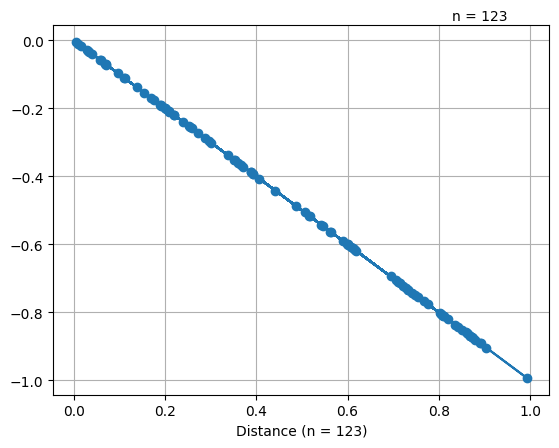

In [18]:
import matplotlib.pyplot as plt
from random import random

plt.figure()
x = [random() for _ in range(100)]
y = [-x_i for x_i in x]
plt.plot(x, y, marker='o', label='Average Score')
plt.xlabel('Distance (n = 123)')
plt.grid(True)
plt.text(0.95, 0.05, "n = 123", horizontalalignment='right', verticalalignment='bottom')
plt.show()